## Вирішення задачі классифікації активності людини за допомогою акселерометра

**1. Завантаження бібліотек**

In [ ]:
#B0
%matplotlib inline
#B1
import os
from pathlib import Path
import numpy as np
#B2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #MinMaxScaler
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#B3
# import my_module

**2. Завантаження даних**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
data_path = "/content/drive/My Drive/DATA homeworks/05/data"

In [ ]:
# Lectors variant
!unzip homework.zip -d /content/
data_path = "/content/data"

Archive:  homework.zip
replace /content/data/idle/idle-1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
activities = os.listdir(data_path)

In [ ]:
activities

['walking', 'idle', 'running', 'stairs']

In [ ]:
data_collections = []

for index, activity in enumerate(activities, start=1): # index?
    activity_path = Path(data_path) / activity
    csv_files = list(activity_path.glob('*.csv'))
    df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
    df['activity'] = activity
    data_collections.append(df)

data = pd.concat(data_collections, ignore_index=True)
data

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,-0.670376,-10.611102,-1.091756,walking
1,-2.360683,-1.594538,2.011129,walking
2,-2.331952,-7.671022,-0.359130,walking
3,-4.395754,-11.573571,-2.039860,walking
4,-9.993398,1.580173,-11.587936,walking
...,...,...,...,...
193855,0.316035,-8.226476,-2.590526,stairs
193856,1.019930,-9.423578,-5.741296,stairs
193857,-0.627281,-8.944737,-6.315904,stairs
193858,-1.082179,-5.779603,-0.483629,stairs


In [ ]:
X = data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = data['activity']

In [ ]:
X

,accelerometer_X,accelerometer_Y,accelerometer_Z
0,-0.670376,-10.611102,-1.091756
1,-2.360683,-1.594538,2.011129
2,-2.331952,-7.671022,-0.359130
3,-4.395754,-11.573571,-2.039860
4,-9.993398,1.580173,-11.587936
...,...,...,...
193855,0.316035,-8.226476,-2.590526
193856,1.019930,-9.423578,-5.741296
193857,-0.627281,-8.944737,-6.315904
193858,-1.082179,-5.779603,-0.483629


In [ ]:
y = pd.DataFrame(y, columns=['activity'])
y

,activity
0,walking
1,walking
2,walking
3,walking
4,walking
...,...
193855,stairs
193856,stairs
193857,stairs
193858,stairs


Lecturer's comment. Additional EDA

General info

In [ ]:
# 1
display(data.info())
# 2
display(data.describe())
# 2
display(data.describe(exclude = float))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   activity         193860 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.9+ MB


None

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


,activity
count,193860
unique,4
top,running
freq,102240


<Axes: xlabel='activity'>

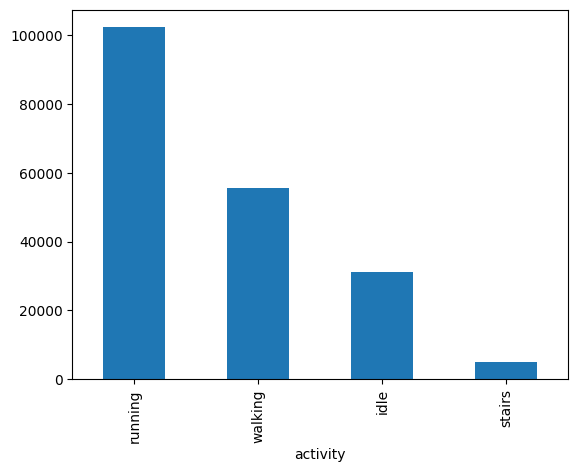

In [ ]:
data['activity'].value_counts().plot(kind='bar')

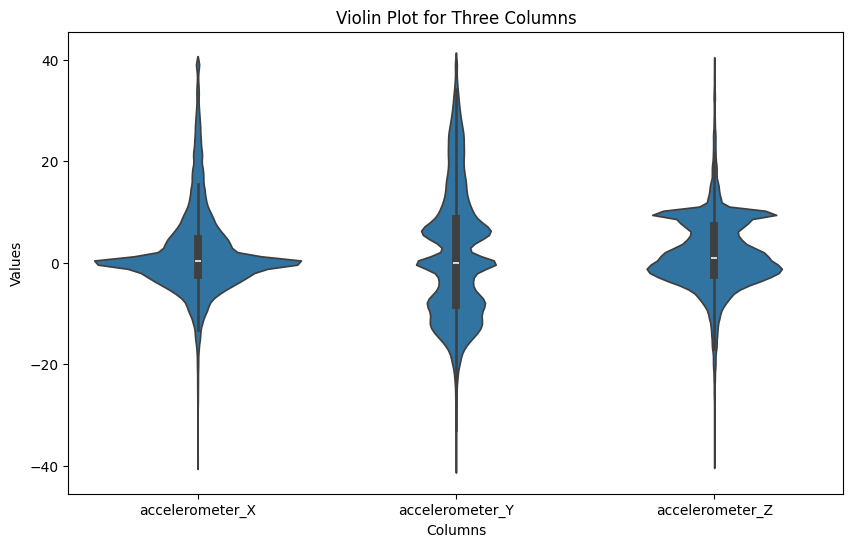

In [ ]:
data_melted = X.melt(var_name='Columns', value_name='Values')
plt.figure(figsize=(10, 6))
sns.violinplot(x='Columns', y='Values', data=data_melted)
plt.title('Violin Plot for Three Columns')
plt.show()

Stat info

In [ ]:
def calculate_mode(series):
    return series.mode().iloc[0]

grouped_data = data.groupby('activity').agg({
    'accelerometer_X': ['mean', 'median', 'min', 'max'],
    'accelerometer_Y': ['mean', 'median', 'min', 'max'],
    'accelerometer_Z': ['mean', 'median', 'min', 'max']
})

mode_data = data.groupby('activity').agg({
    'accelerometer_X': calculate_mode,
    'accelerometer_Y': calculate_mode,
    'accelerometer_Z': calculate_mode
})

agg_data = pd.concat([grouped_data, mode_data], axis = 1)
agg_data.rename(columns = {'accelerometer_X': ('accelerometer_X', 'mode'),
                          'accelerometer_Y': ('accelerometer_Y', 'mode'),
                          'accelerometer_Z': ('accelerometer_Z', 'mode')}, inplace = True)
agg_data

,"(accelerometer_X, mean)","(accelerometer_X, median)","(accelerometer_X, min)","(accelerometer_X, max)","(accelerometer_Y, mean)","(accelerometer_Y, median)","(accelerometer_Y, min)","(accelerometer_Y, max)","(accelerometer_Z, mean)","(accelerometer_Z, median)","(accelerometer_Z, min)","(accelerometer_Z, max)","(accelerometer_X, mode)","(accelerometer_Y, mode)","(accelerometer_Z, mode)"
activity,,,,,,,,,,,,,,,
idle,0.096767,0.234632,-10.448297,8.135497,2.225971,0.028730,-2.595315,9.916783,8.973247,9.749189,-0.296881,21.988348,0.263362,-0.014365,9.763555
running,5.045705,3.605668,-39.188293,39.188293,8.083135,7.967903,-39.188293,39.188293,1.387356,0.407014,-39.188293,39.188293,39.188293,39.188293,-2.753332
stairs,0.353135,0.483629,-11.238382,14.164097,-9.574353,-8.944737,-25.828648,4.994305,-1.841333,-1.589750,-38.086960,17.492037,0.991200,-9.251195,-6.210559
walking,-2.661943,-2.298433,-26.815060,20.575770,-9.703702,-9.974244,-39.188293,14.441825,-1.126623,-0.933739,-39.169140,38.426937,-1.944092,-12.703634,-0.742202


In [ ]:
agg_data.columns = [
            ('accelerometer_X',   'mean'),
            ('accelerometer_X', 'median'),
            ('accelerometer_X',    'min'),
            ('accelerometer_X',    'max'),
            ('accelerometer_X',   'mode'),
            ('accelerometer_Y',   'mean'),
            ('accelerometer_Y', 'median'),
            ('accelerometer_Y',    'min'),
            ('accelerometer_Y',    'max'),
            ('accelerometer_Y',   'mode'),
            ('accelerometer_Z',   'mean'),
            ('accelerometer_Z', 'median'),
            ('accelerometer_Z',    'min'),
            ('accelerometer_Z',    'max'),
            ('accelerometer_Z',   'mode')
            ]
agg_data.columns = pd.MultiIndex.from_tuples(agg_data.columns)
agg_data

accelerometer_X                                            \
                    mean    median        min        max      mode   
activity                                                             
idle            0.096767  0.234632 -10.448297   8.135497  2.225971   
running         5.045705  3.605668 -39.188293  39.188293  8.083135   
stairs          0.353135  0.483629 -11.238382  14.164097 -9.574353   
walking        -2.661943 -2.298433 -26.815060  20.575770 -9.703702   

         accelerometer_Y                                            \
                    mean     median        min       max      mode   
activity                                                             
idle            0.028730  -2.595315   9.916783  8.973247  9.749189   
running         7.967903 -39.188293  39.188293  1.387356  0.407014   
stairs         -8.944737 -25.828648   4.994305 -1.841333 -1.589750   
walking        -9.974244 -39.188293  14.441825 -1.126623 -0.933739   

         accelerometer_Z                                             
                    mean     median        min        max      mode  
activity                                                             
idle           -0.296881  21.988348   0.263362  -0.014365  9.763555  
running       -39.188293  39.188293  39.188293  39.188293 -2.753332  
stairs        -38.086960  17.492037   0.991200  -9.251195 -6.210559  
walking       -39.169140  38.426937  -1.944092 -12.703634 -0.742202

In [ ]:
to_view = agg_data.columns.values[4::5]
agg_data[to_view]

,accelerometer_X,accelerometer_Y,accelerometer_Z
,mode,mode,mode
activity,,,
idle,2.225971,9.749189,9.763555
running,8.083135,0.407014,-2.753332
stairs,-9.574353,-1.589750,-6.210559
walking,-9.703702,-0.933739,-0.742202


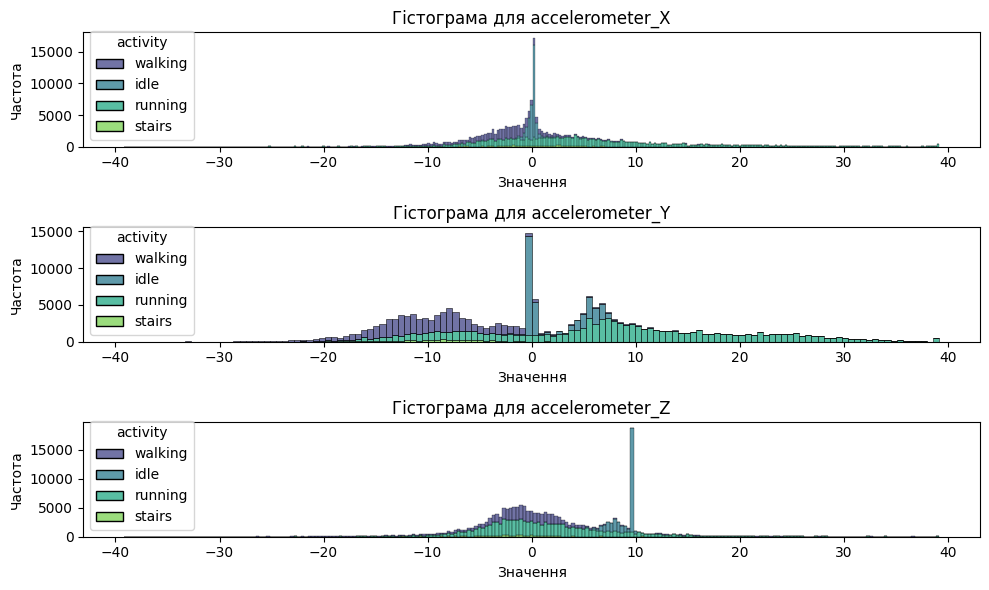

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

for idx, column in enumerate(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']):
    sns.histplot(data=data, x=column, hue='activity', multiple='stack', palette='viridis', ax=axes[idx])
    axes[idx].set_title(f'Гістограма для {column}')
    axes[idx].set_xlabel('Значення')
    axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

**3. Розрахунок часових ознак**

In [ ]:
def mean(x):
    return x.mean()

def median(x): # Lecturer's comment
  return x.median()

def std(x):
    return x.std()

def max_value(x):
    return x.max()

def min_value(x):
    return x.min()

def rms(x):
    return np.sqrt((x ** 2).mean())

def peak_to_peak(x):
    return x.max() - x.min()

def autocorrelation(x):
    lag = 1
    corr = np.correlate(x, x[lag:], mode='full')[lag]
    return corr / x.std() ** 2

X_new = []
for signal in X[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].to_numpy():
    features = [
        mean(signal),
        std(signal),
        max_value(signal),
        min_value(signal),
        rms(signal),
        peak_to_peak(signal),
        autocorrelation(signal)
    ]
    X_new.append(features)

X_new = pd.DataFrame(X_new, columns=['mean',
                                     'std',
                                     'max',
                                     'min',
                                     'rms',
                                     'peak_to_peak',
                                     'autocorrelation'
                                     ]
                     )

In [ ]:
X_new

,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-6.418057,6.896229,-0.167594,-16.026787,9.420692,15.859193,1.087611
1,15.662868,9.596737,27.562050,4.060566,18.369071,23.501484,5.813800
2,-0.727837,5.781748,7.240066,-6.301539,5.827380,13.541605,-2.040986
3,7.562485,13.822908,26.139894,-6.995857,15.756394,33.135751,-0.472314
4,-4.866614,14.176176,5.822699,-24.899698,14.988259,30.722397,-1.276166
...,...,...,...,...,...,...,...
194155,-4.047797,3.691136,-0.761356,-9.203311,5.478060,8.441955,1.986017
194156,-1.722229,1.821782,0.253785,-4.141969,2.506983,4.395754,1.278848
194157,-3.240153,2.357770,-0.330400,-6.105214,4.007202,5.774814,3.970414
194158,-3.296017,3.669826,1.455675,-7.479486,4.932682,8.935161,1.337640


In [ ]:
X = pd.concat([X, X_new], axis=1)

In [ ]:
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-0.167594,-16.026787,-3.059790,-6.418057,6.896229,-0.167594,-16.026787,9.420692,15.859193,1.087611
1,15.365987,27.562050,4.060566,15.662868,9.596737,27.562050,4.060566,18.369071,23.501484,5.813800
2,-6.301539,7.240066,-3.122039,-0.727837,5.781748,7.240066,-6.301539,5.827380,13.541605,-2.040986
3,3.543419,26.139894,-6.995857,7.562485,13.822908,26.139894,-6.995857,15.756394,33.135751,-0.472314
4,4.477157,-24.899698,5.822699,-4.866614,14.176176,5.822699,-24.899698,14.988259,30.722397,-1.276166
...,...,...,...,...,...,...,...,...,...,...
194155,-0.761356,-9.203311,-2.178723,-4.047797,3.691136,-0.761356,-9.203311,5.478060,8.441955,1.986017
194156,-1.278504,-4.141969,0.253785,-1.722229,1.821782,0.253785,-4.141969,2.506983,4.395754,1.278848
194157,-0.330400,-6.105214,-3.284845,-3.240153,2.357770,-0.330400,-6.105214,4.007202,5.774814,3.970414
194158,1.455675,-7.479486,-3.864241,-3.296017,3.669826,1.455675,-7.479486,4.932682,8.935161,1.337640


**4.  EDA**

In [ ]:
scaler = StandardScaler() #MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns.values.tolist())
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-0.249395,-1.413716,-0.676669,-1.134603,0.436399,-0.934877,-1.557344,0.212401,0.411138,-0.016700
1,1.598314,2.080679,0.313468,1.920980,1.284933,2.141996,1.162730,1.950224,1.432811,-0.012711
2,-0.979024,0.451523,-0.685325,-0.347184,0.086214,-0.112925,-0.240426,-0.485439,0.101307,-0.019342
3,0.192027,1.966669,-1.224008,0.800040,2.612851,1.984194,-0.334445,1.442828,2.720785,-0.018017
4,0.303095,-2.125032,0.558506,-0.919913,2.723853,-0.270196,-2.758846,1.293652,2.398152,-0.018696
...,...,...,...,...,...,...,...,...,...,...
194155,-0.320023,-0.866697,-0.554150,-0.806604,-0.570683,-1.000761,-0.633362,-0.553279,-0.580448,-0.015942
194156,-0.381538,-0.460943,-0.215892,-0.484789,-1.158059,-0.888121,0.052006,-1.130278,-1.121372,-0.016539
194157,-0.268761,-0.618331,-0.707964,-0.694841,-0.989644,-0.952942,-0.213841,-0.838928,-0.937010,-0.014267
194158,-0.056309,-0.728502,-0.788534,-0.702572,-0.577379,-0.754760,-0.399935,-0.659194,-0.514513,-0.016489


**4.1. Кореляція фіч між собою**

<Axes: >

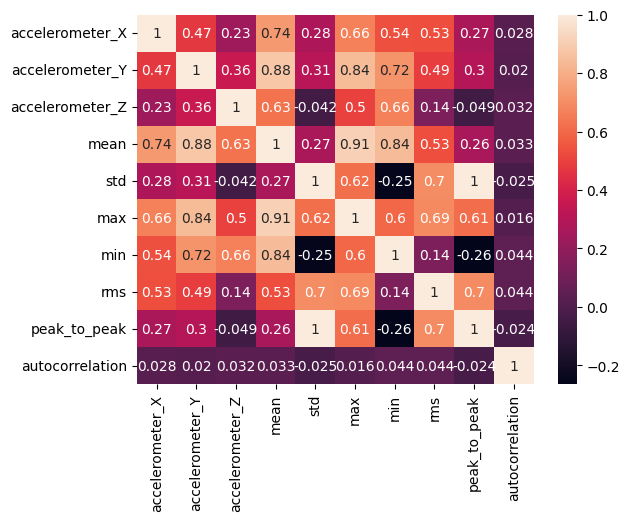

In [ ]:
corr_x = X.corr()
sns.heatmap (corr_x, annot=True)

In [ ]:
X = X.drop('peak_to_peak', axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_new = labelencoder.fit_transform(y.values)
y_new

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 3, 3, ..., 2, 2, 2])

In [ ]:
pd.Series(y_new).value_counts()

1    102240
3     55500
0     31170
2      4950
Name: count, dtype: int64

**5. Відбір фіч**

In [ ]:
f_stats, p_values = f_regression(X, y_new)
for i, (feature, f_stat, p_value) in enumerate(zip(range(X.shape[1]), f_stats, p_values)):
    print(f"Feature {i}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

selected_features = np.where(p_values < 0.05)[0]
print("Selected Features:", selected_features)

Feature 0: F-statistic=14575.6782, p-value=0.0000
Feature 1: F-statistic=69965.1391, p-value=0.0000
Feature 2: F-statistic=32878.2027, p-value=0.0000
Feature 3: F-statistic=73816.9461, p-value=0.0000
Feature 4: F-statistic=592.2295, p-value=0.0000
Feature 5: F-statistic=55144.2910, p-value=0.0000
Feature 6: F-statistic=76095.5716, p-value=0.0000
Feature 7: F-statistic=139.8314, p-value=0.0000
Feature 8: F-statistic=0.0002, p-value=0.9901
Selected Features: [0 1 2 3 4 5 6 7]


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

sfm = SelectFromModel(rf_model, prefit=True)
X_rf_selected = sfm.transform(X)

print("Original number of features:", X.shape[1])
print("Selected number of features:", X_rf_selected.shape[1])

<ipython-input-19-aed16d3770f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X, y)


Original number of features: 9
Selected number of features: 4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
X_rf_selected

array([[-1.41371568, -0.67666886, -1.13460347, -0.93487724],
       [ 2.08067948,  0.31346828,  1.92098004,  2.14199626],
       [ 0.45152285, -0.68532503, -0.34718439, -0.11292537],
       ...,
       [-0.61833092, -0.70796439, -0.69484149, -0.95294215],
       [-0.72850247, -0.78853361, -0.70257206, -0.75475977],
       [-0.86247413, -0.82848531, -0.78562104, -0.73722625]])

**6. Розподілення даних на навчальну і тестову выбірки**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

In [ ]:
X_rf_selected_train, X_rf_selected_test, y_train, y_test = train_test_split(X_rf_selected, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

 **7. Навчання та оцінка моделей**


**7.1. SVM**

**7.1.1. Усі фічі**

In [ ]:
# Lecturer's comment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[('preprocessor', StandardScaler()),
                           ('classifier', SVC(random_state=42))])

param_dist = {
    'classifier__С': [0.25, 0.5, 1, 2, 4],
    'classifier__kernel': ['linear', 'rbf']
    }

random_search = GridSearchCV(pipeline,
                                param_distributions=param_dist,
                                scoring='f1',
                                cv=3,
                                random_state=42)

random_search.fit(X_train, y_train)
print("Best Parameters: ", random_search.best_params_)
print("Best Scoring: {:.2f}".format(random_search.best_score_))

y_pred_svm = random_search.predict(X_test)
print('Отчет о классификации SVM with time domain features:')
print(classification_report(y_test, y_pred_svm))

In [ ]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print('Отчет о классификации SVM with time domain features:')
print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Отчет о классификации SVM with time domain features:
              precision    recall  f1-score   support

        idle       0.97      0.98      0.98      6234
     running       0.93      0.91      0.92     20508
      stairs       1.00      0.00      0.00       990
     walking       0.81      0.90      0.85     11100

    accuracy                           0.90     38832
   macro avg       0.93      0.70      0.69     38832
weighted avg       0.90      0.90      0.89     38832



In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_svm

array([[ 6138,    80,     0,    16],
       [  190, 18700,     0,  1618],
       [    6,   289,     2,   693],
       [   20,  1085,     0,  9995]])

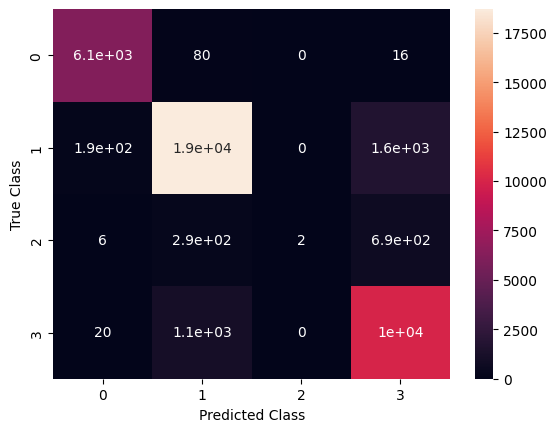

In [ ]:
sns.heatmap(conf_matrix_svm, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.1.2 Фічі з f-regression**

In [ ]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_rf_selected_train, y_train)

y_pred_svm_select = svm_model.predict(X_rf_selected_test)

print('Отчет о классификации SVM with time domain features (f-regression selection):')
print(classification_report(y_test, y_pred_svm_select))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Отчет о классификации SVM with time domain features (f-regression selection):
              precision    recall  f1-score   support

        idle       0.95      0.99      0.97      6234
     running       0.93      0.90      0.91     20508
      stairs       1.00      0.00      0.00       990
     walking       0.80      0.90      0.85     11100

    accuracy                           0.89     38832
   macro avg       0.92      0.70      0.68     38832
weighted avg       0.90      0.89      0.88     38832



In [ ]:
conf_matrix_svm_select = confusion_matrix(y_test, y_pred_svm_select)
conf_matrix_svm_select

array([[ 6145,    71,     0,    18],
       [  296, 18367,     0,  1845],
       [   12,   268,     2,   708],
       [   48,  1015,     0, 10037]])

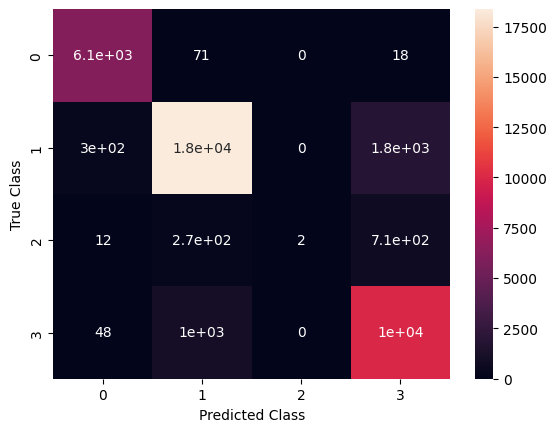

In [ ]:
sns.heatmap(conf_matrix_svm_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2. Random Forest**

**7.2.1 Усі фічі**

**7.2.1.1 max_depth=3**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=3,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_3 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_3))

<ipython-input-34-d28558a1cebb>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Отчет о классификации Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        idle       0.97      0.96      0.97      6234
     running       0.89      0.91      0.90     20508
      stairs       0.00      0.00      0.00       990
     walking       0.79      0.84      0.82     11100

    accuracy                           0.88     38832
   macro avg       0.67      0.68      0.67     38832
weighted avg       0.85      0.88      0.86     38832



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
conf_matrix_rf_3 = confusion_matrix(y_test, y_pred_rf_3)
conf_matrix_rf_3

array([[ 5982,   238,     0,    14],
       [  131, 18648,     0,  1729],
       [    3,   304,     0,   683],
       [   20,  1724,     0,  9356]])

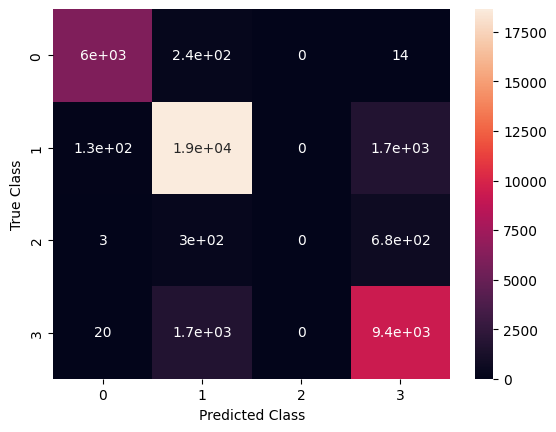

In [ ]:
sns.heatmap(conf_matrix_rf_3, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2.1.2 max_depth=15**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_15 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_15))

<ipython-input-36-62d025f61e98>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Отчет о классификации Random Forest:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20508
      stairs       1.00      0.80      0.89       990
     walking       0.96      1.00      0.98     11100

    accuracy                           0.99     38832
   macro avg       0.99      0.95      0.97     38832
weighted avg       0.99      0.99      0.99     38832



In [ ]:
conf_matrix_rf_15 = confusion_matrix(y_test, y_pred_rf_15)
conf_matrix_rf_15

array([[ 6232,     0,     0,     2],
       [    3, 20261,     0,   244],
       [    1,     8,   795,   186],
       [    0,     6,     0, 11094]])

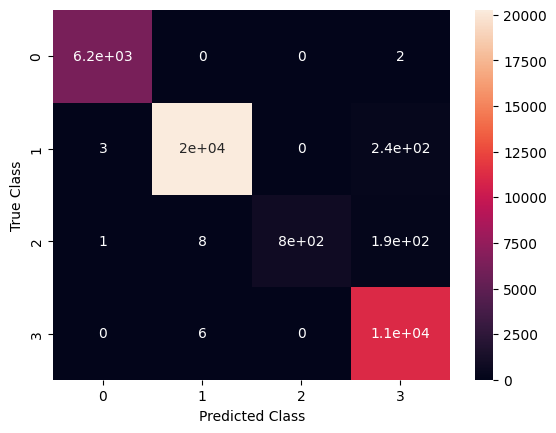

In [ ]:
sns.heatmap(conf_matrix_rf_15, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2.2 фічі з SelectFromMode**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_rf_selected_train, y_train)

y_pred_rf_select = rf_model.predict(X_rf_selected_test)

print('Отчет о классификации Random Forest (SelectFromModel Features):')
print(classification_report(y_test, y_pred_rf_select))

<ipython-input-29-fadbeab2fbf3>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_rf_selected_train, y_train)


Отчет о классификации Random Forest (SelectFromModel Features):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20508
      stairs       1.00      0.83      0.91       990
     walking       0.97      1.00      0.98     11100

    accuracy                           0.99     38832
   macro avg       0.99      0.96      0.97     38832
weighted avg       0.99      0.99      0.99     38832



In [ ]:
conf_matrix_rf_select = confusion_matrix(y_test, y_pred_rf_select)
conf_matrix_rf_select

array([[ 6231,     3,     0,     0],
       [   17, 20307,     0,   184],
       [    3,    11,   824,   152],
       [    9,     9,     0, 11082]])

In [ ]:
# Lecturer's comment
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=cache%20(in%20MB).-,class_weight,-dict%20or%20%E2%80%98balanced

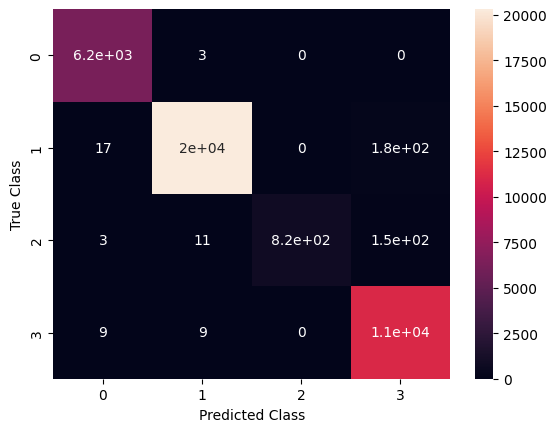

In [ ]:
sns.heatmap(conf_matrix_rf_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()